In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import copy
import math
from sklearn_extra.cluster import KMedoids
        
def get_medoids(G, n_clusters):
    """
    Divide all honest cells into n_clusters clusters. The medoids will be the attacked nodes.
    """
    dist_matrix = np.array(nx.floyd_warshall_numpy(G))
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=0).fit(dist_matrix)
    return kmedoids.medoid_indices_

def create_spread_attack_graph(G, attacked, max_degree, number_of_nodes):
    """
    Divide all attacked nodes into clusters of size max_degree at most and assign sybil nodes
    """
    dist_matrix = np.array(nx.floyd_warshall_numpy(G.subgraph(range(number_of_nodes))))
    unassigned = set(attacked)
    total_nodes = len(G)
    cluster_number = 1
    while unassigned:
        seed_node = random.choice(list(unassigned))
        unassigned.remove(seed_node)
        cluster = set([seed_node])
        for i in range(max_degree - 1):
            if not unassigned:
                break
            closest = find_closest_node(G, cluster, dist_matrix, unassigned)
            cluster.add(closest)
            unassigned.remove(closest)

        for n in cluster:
            G.add_edge(n, total_nodes + cluster_number)
        cluster_number += 1
        
def find_closest_node(G, nodes, dist_matrix, unassigned):
    closest_node = None
    closest_dist = float('inf')
    for node in G.nodes():
        if node in unassigned:
            dist_to_nodes = np.min(dist_matrix[node][list(nodes)])
            if dist_to_nodes < closest_dist:
                closest_node = node
                closest_dist = dist_to_nodes
    return closest_node
    

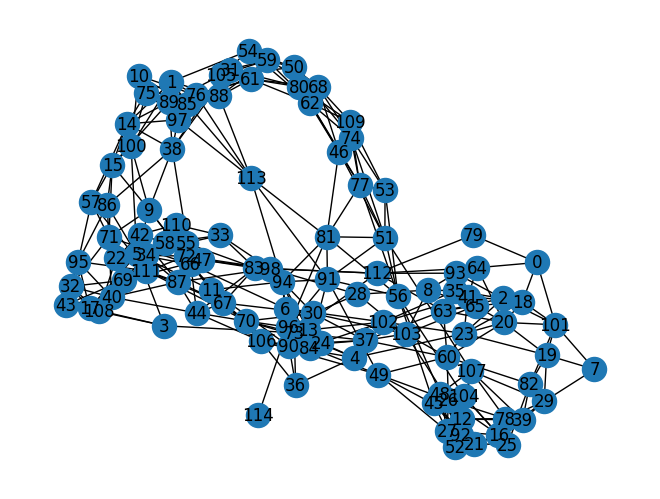

In [4]:
number_of_nodes = 99

# Set max degree for every node
max_degree = 7

phi = 1
seed = 2

G = nx.random_geometric_graph(99, 0.2, seed=seed)
random.seed(seed)

for node in G.nodes:
    while G.degree(node) > max_degree:
        edges = list(G.edges(node))
        G.remove_edge(*edges[random.randint(0, len(edges) - 1)])


attacked = list()
if phi % 1 != 0:
    attacked = get_medoids(G, int(len(G) * (phi % 1)))

create_spread_attack_graph(G, attacked, max_degree, number_of_nodes)

for _ in range(int(phi)):
    create_spread_attack_graph(G, range(number_of_nodes), max_degree, number_of_nodes)

nx.draw(G, with_labels=True)

a = nx.adjacency_matrix(G)
from scipy.sparse import csr_matrix, find
find(a)
adj = []
for i in range(len(G)):
    for j in a[[i], :]:
        adj.append(j.toarray()[0])



In [6]:
pd.DataFrame(adj).to_csv("99_1_phi.csv", index=None)

In [7]:
print(min(list(map(lambda x: sum(x), adj[:199]))))
print(max(list(map(lambda x: sum(x), adj[:199]))))

1
8
